In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import shuffle
from xgboost import XGBRegressor
# import itertools
# import time

In [2]:
df_0 = pd.read_csv('RawData/two_widths/Param0_2width.csv')
df_1 = pd.read_csv('RawData/two_widths/Param1_2width.csv')
df_2 = pd.read_csv('RawData/two_widths/Param2_2width.csv')
df_3 = pd.read_csv('RawData/two_widths/Param3_2width.csv')
df_4 = pd.read_csv('RawData/two_widths/Param4_2width.csv')

df1 = pd.concat([df_0, df_1, df_2, df_3, df_4], axis = 0, ignore_index = True)
print(df1.keys())
df1 = shuffle(df1, random_state=20210614)

Index(['Frequency', 'Speed', 'Amplitude', 'Passes', 'Focal_Position', 'Depth',
       'Top_width', 'Bot_width'],
      dtype='object')


In [3]:
# ###------- normalizing data 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(df1)

column_names = ['f or V', 'Speed', 'A', 'N', 'F$_l$', 'Depth', 'Top_width', 'Bot_width']

df = pd.DataFrame(df_norm, columns=column_names )
print(df.keys())

Index(['f or V', 'Speed', 'A', 'N', 'F$_l$', 'Depth', 'Top_width',
       'Bot_width'],
      dtype='object')


In [4]:
X = df.drop(['Depth', 'Top_width', 'Bot_width', 'Speed'], axis = 'columns')
Dpt = df.Depth.values
Topw = df.Top_width.values
Botw = df.Bot_width.values

##-------- split the data to training (80%) and test (20%) data sets
Xtrain, Xtest,Dpt_train, Dpt_test, Topw_train, Topw_test, Botw_train, Botw_test  =\
            train_test_split(X, Dpt,Topw ,Botw ,
            test_size = 0.2, random_state = 20210614)

In [5]:
# ##-------- If you want to predict Depth
Y_train1 = np.c_[Dpt_train]
Y_test1 = np.c_[Dpt_test]

# # # ##-------- If you want to predict Top width
Y_train2 = np.c_[Topw_train]
Y_test2 = np.c_[Topw_test]


# # # # ##-------- If you want to predict Bottom width
Y_train3 = np.c_[Botw_train]
Y_test3 = np.c_[Botw_test]

In [20]:
"""
Tree: as we don't have many data points we use
XGBoosting and find the best params
"""
XGB_Dpt = XGBRegressor(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20210614,        # Seed
                            missing=1                  # How are nulls encoded?
                            )

param_grid = dict({'n_estimators': [50, 100],
                    'max_depth': [5, 7, 9],
                    'learning_rate': [0.01, 0.1],
                    'subsample': [0.632, 1.] 
                  })

# # Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
# val_train = bankloan_train_noWoE.sample(frac = 0.3,                 # The fraction to extract
#                                        random_state = 20201107   # The seed
#                                        )

# Define grid search object.
GridXGB = GridSearchCV(XGB_Dpt,        # Original XGB.
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross validation folds.
                       n_jobs = 4,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually
                       verbose = 1           # If to show what it is doing
                      )




In [21]:
# Train grid search.
GridXGB.fit(Xtrain, Y_train1)

# Show best params
print(GridXGB.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.632}


In [22]:
"""let's look at the feature importance, using the XGB results
for depth: 
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.632}

for top width:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}

for bot width:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.632}

"""

XGB = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'),                 # Depth of each tree
                    learning_rate=GridXGB.best_params_.get('learning_rate'),            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                    n_estimators=GridXGB.best_params_.get('n_estimators'),             # How many trees to use, the more the better, but decrease learning rate if many used.
                    verbosity=1,                  # If to show more errors or not.
                    objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                    booster='gbtree',             # What to boost. Trees in this case.
                    n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                    gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                    subsample=GridXGB.best_params_.get('subsample'),              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                    colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                    colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                    colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                    reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                    reg_lambda=0,                 # Regularizer for first fit.
                    scale_pos_weight=1,           # Balancing of positive and negative weights.
                    base_score=0.5,               # Global bias. Set to average of the target rate.
                    random_state=20210614,        # Seed
                    missing=1                  # How are nulls encoded?
                    )



In [23]:
# XGB.fit(Xtrain, Y_train1)

# importance = XGB.feature_importances_

# indices = np.argsort(importance)[::-1]

# f, ax = plt.subplots(figsize=(5, 5))
# plt.title("Variable Importance on depth prediction", fontsize=20)
# sns.set_color_codes("muted")
# sns.barplot(y = [Xtrain.columns[i] for i in indices],
#             x = importance[indices], capsize=40)

# ax.set(ylabel = 'Variable', xlabel = 'Variable Importance (Gini)')
# sns.despine(left = True, bottom = True)

# # plt.savefig('Graphs/VarImp_Ang.png',bbox_inches='tight')
# plt.show()

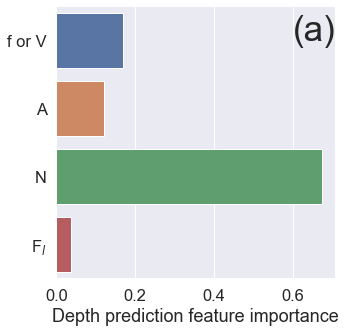

In [24]:
XGB.fit(Xtrain, Y_train1)

importance = XGB.feature_importances_

# indices = np.argsort(importance)[::-1]

indices = np.arange(4)

sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(5, 5))
# plt.title("Variable Importance on Angle prediction", fontsize=20)
sns.set_color_codes("muted")
sns.barplot(y = [Xtrain.columns[i] for i in indices],
            x = importance[indices], capsize=40)

ax.set(xlabel = 'Depth prediction feature importance')
sns.despine(left = True, bottom = True)
ax.annotate('(a)', xy = (0.6,0), fontsize=35)


plt.savefig('Graphs/VarImp_depth.png',bbox_inches='tight')
plt.show()

In [12]:
# Train grid search.
GridXGB.fit(Xtrain, Y_train2)

# Show best params
print(GridXGB.best_params_)

XGB = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'),                 # Depth of each tree
                    learning_rate=GridXGB.best_params_.get('learning_rate'),            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                    n_estimators=GridXGB.best_params_.get('n_estimators'),             # How many trees to use, the more the better, but decrease learning rate if many used.
                    verbosity=1,                  # If to show more errors or not.
                    objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                    booster='gbtree',             # What to boost. Trees in this case.
                    n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                    gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                    subsample=GridXGB.best_params_.get('subsample'),              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                    colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                    colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                    colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                    reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                    reg_lambda=0,                 # Regularizer for first fit.
                    scale_pos_weight=1,           # Balancing of positive and negative weights.
                    base_score=0.5,               # Global bias. Set to average of the target rate.
                    random_state=20210614,        # Seed
                    missing=1                  # How are nulls encoded?
                    )

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}


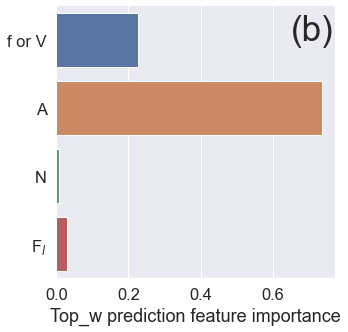

In [14]:
XGB.fit(Xtrain, Y_train2)

importance = XGB.feature_importances_

# indices = np.argsort(importance)[::-1]

indices = np.arange(4)

sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(5, 5))
# plt.title("Variable Importance on Angle prediction", fontsize=20)
sns.set_color_codes("muted")
sns.barplot(y = [Xtrain.columns[i] for i in indices],
            x = importance[indices], capsize=40)

ax.set(xlabel = 'Top_w prediction feature importance')
sns.despine(left = True, bottom = True)
ax.annotate('(b)', xy = (0.65,0), fontsize=35)

plt.savefig('Graphs/VarImp_Topwidth.png',bbox_inches='tight')
plt.show()

In [15]:
# Train grid search.
GridXGB.fit(Xtrain, Y_train3)

# Show best params
print(GridXGB.best_params_)

XGB = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'),                 # Depth of each tree
                    learning_rate=GridXGB.best_params_.get('learning_rate'),            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                    n_estimators=GridXGB.best_params_.get('n_estimators'),             # How many trees to use, the more the better, but decrease learning rate if many used.
                    verbosity=1,                  # If to show more errors or not.
                    objective='reg:squarederror',  # Type of target variable. for classifieer use 'binary:logistic'
                    booster='gbtree',             # What to boost. Trees in this case.
                    n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                    gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                    subsample=GridXGB.best_params_.get('subsample'),              # Subsample ratio. Can set lower than 1. If we want perfect boosting
                    colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                    colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest. sqrt(no.var)
                    colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                    reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                    reg_lambda=0,                 # Regularizer for first fit.
                    scale_pos_weight=1,           # Balancing of positive and negative weights.
                    base_score=0.5,               # Global bias. Set to average of the target rate.
                    random_state=20210614,        # Seed
                    missing=1                  # How are nulls encoded?
                    )

Fitting 3 folds for each of 24 candidates, totalling 72 fits
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.632}


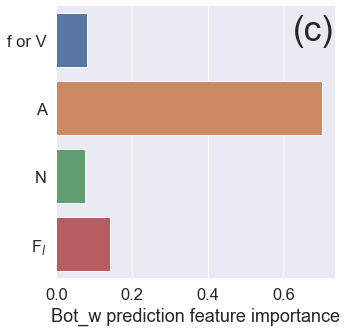

In [19]:
XGB.fit(Xtrain, Y_train3)

importance = XGB.feature_importances_

# indices = np.argsort(importance)[::-1]

indices = np.arange(4)
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(5, 5))

# plt.title("Variable Importance on Angle prediction", fontsize=20)
# sns.set_color_codes(palette='deep')
sns.set_color_codes("muted")
sns.barplot(y = [Xtrain.columns[i] for i in indices],
            x = importance[indices], capsize=50)

ax.set(xlabel = 'Bot_w prediction feature importance')
sns.despine(left = True, bottom = True)
ax.annotate('(c)', xy = (0.625,0), fontsize=35)
# sns.set(font_scale = 2)
plt.savefig('Graphs/VarImp_BotWidth.png',bbox_inches='tight')
plt.show()